# Online EdX experiment evaluation
A/B experiment was conducted on [CaltechDelftX: QuCryptox Quantum cryptography](https://courses.edx.org/courses/course-v1:CaltechDelftX+QuCryptox+3T2016) MOOC course offered by **Caltech University** and **TU Delft** at **EdX platform**. In this document, we are evaluating our proposed **question routing (recommendation of new questions) framework**. Users were split into three groups:

1. Question recommendation group *with educational-context*. Further reffered as **1.Educational context** or **Edu** 
2. Baseline group - question recommendation without considering educational-context. Further reffered as **2.Baseline**.   
3. Control group without question recommendation. Further reffered as **3.Control**

Please notice that users in both 1.Educational context group and 2. Baseline group have question recommendation. However, the method for generating recommendations in 2. Baseline group is not considering educational features (grades, knowledge gap, portion of seen lectures within categories in the online course, portion of seen questions within categories in CQA system, average activity in the online course and lecture freshness). Both educational context group and baseline group had constrainst on number of recommendation for user per week (4 per 7 days).

Course lasted 11 weeks from 3th October 2016(week \#0) to 20th December 2016(week \#10). Online experiment started 14th November 2016 (start of week \#6). Welcome category where student greet themselves is not considered (category_id = 2). Analysed data are from period two weeks before (26th September 2016) and after (2nd January 2017) course. Therefore, period before and during online experiments are equal (both lasting 7 weeks).

Recommendation was delivered to user by notification:
![notification](images/askalot-notification.PNG)

And all recommendations for a user were also shown on the dashboard:
![dashboard recommendation](images/dashboard-rec.PNG)

In [47]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib
matplotlib.style.use('ggplot')
from IPython.display import display
import scipy.stats as stats
from matplotlib.ticker import FormatStrFormatter
from statsmodels.stats import weightstats

# graphics setup
%matplotlib inline
sns.set(color_codes=True)
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})

# set up connection to the database
connection = pg.connect(database="askalot_edx_development", user="postgres", port=5432, 
                        host="localhost", password="")

## Users in recommendation groups are distributed evenly 

Users were sorted according to their answers count at the start of the online experiment. Subsequently, they were divided to groups by modulo operation of their order.

Pseudocode:
```
Sort users according to their answers count.
for i in lenght(sorted_users):
      ab_group[(i % 3) +1] <- sorted_users[i] 
```

In [48]:
ab_groups =  psql.read_sql("""SELECT id as ab_group_id, value as "ab_group" FROM ab_groups""", connection)
user_groups = psql.read_sql("""SELECT g.id, g.value as "Name", COUNT(*) as "User count" FROM ab_groupings ab
                         JOIN ab_groups g ON g.id=ab.ab_group_id GROUP BY g.id ORDER BY g.id""", connection)
user_groups

,id,Name,User count
0,1,Question routing full,1306
1,2,Question routing baseline,1306
2,3,Control group for question routing,1306


Users who signed up for the course during online experiment did not get assigned to any group and are not considered in evaluation.

## Question routing recommended 132 questions during online experiment
Each question was recommended to both 10 most suitable users from educational-context group and to 10 most suitable users from group without educational context which resulted into 1320 recommendations for each group with recommendation. 

In [49]:
rec_questions_count = psql.read_sql("""
                                SELECT g.id, g.value, COUNT(DISTINCT(n.resource_id)) AS "Total number of recommended questions" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation'
                                AND resource_id IN (SELECT id FROM questions WHERE category_id <> 2 AND created_at >= '2016-09-26' AND created_at <= '2017-01-02') 
                                GROUP BY g.id
                              """, connection)
rec_count = psql.read_sql("""
                                SELECT g.id, COUNT(DISTINCT(n.id)) AS "Total number of generated recommendations" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation'
                                AND resource_id IN (SELECT id FROM questions WHERE category_id <> 2 AND created_at >= '2016-09-26' AND created_at <= '2017-01-02') 
                                GROUP BY g.id
                              """, connection)
rec_count = pd.merge(rec_questions_count, rec_count, on="id", how='inner')
rec_count[['value', 'Total number of recommended questions', 'Total number of generated recommendations']]

,value,Total number of recommended questions,Total number of generated recommendations
0,Question routing full,132,1320
1,Question routing baseline,132,1320


## Recommendation click-through rate was more than 23% for educational group
Recommendation was sent to users by two channels:

1. as a notification in Askalot CQA system
2. personlized recommended list of questions is shown on user dashboard 

Click-through rate is computed as portion of read recommendations to total number of recommendations.

In [50]:
ctr = psql.read_sql("""   
    SELECT g.value, COUNT(DISTINCT(n.recipient_id)) AS "Unique users received", 
    SUM(case when n.unread = true then 0 else 1 end) / CAST(COUNT(*) AS FLOAT) as "CTR",
    COUNT(*) AS "Number of recommendations"
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND resource_id IN (select id from questions where category_id <> 2 AND created_at >= '2016-09-26' AND created_at <= '2017-01-02' AND deleted=false) 
    GROUP BY g.id ORDER BY g.id
    """,connection)
display(ctr)

,value,Unique users received,CTR,Number of recommendations
0,Question routing full,140,0.232520,1230
1,Question routing baseline,131,0.182927,1230


Group with educational context has better CTR by 4.96% and it has 9 more unique users who received a recommendation. 

### Question routing with educational-context has better recommendation success rate
Recommendation success rate is portion of recommendations where the recipient of the recommendation did any activity (answer, comment, voting, watching topic) to total number of recommended questions.

In [51]:
success_rec_by_groups = psql.read_sql("""
SELECT g.value, 
       COUNT(DISTINCT(n.recipient_id)) AS "Unique users",
         COUNT(distinct case when n.id in (
                SELECT distinct case when ans.id is not null or qc.id is not null or ac.id is not null or v.id is not null or w.id is not null then n.id else null end as successful_rec
                FROM notifications as n
                LEFT JOIN answers ans ON n.recipient_id = ans.author_id AND n.resource_id=ans.question_id AND ans.deleted = false
                LEFT JOIN comments qc ON n.recipient_id = qc.author_id AND n.resource_id=qc.commentable_id AND qc.commentable_type = 'Shared::Question' AND qc.deleted = false
                LEFT JOIN comments ac ON n.recipient_id = ac.author_id AND n.resource_id=ac.commentable_id AND ac.commentable_type = 'Shared::Answer' AND ac.deleted = false
                LEFT JOIN votes v ON n.recipient_id = v.voter_id AND n.resource_id=v.votable_id AND v.votable_type = 'Shared::Question' AND v.deleted = false
                LEFT JOIN watchings w ON n.recipient_id = w.watcher_id AND n.resource_id=w.watchable_id AND w.watchable_type = 'Shared::Question' AND w.deleted = false
                WHERE n.action= 'recommendation' AND n.resource_id IN (select id from questions where category_id <> 2 AND created_at >= '2016-09-26' AND created_at <= '2017-01-02')
        )
        then n.resource_id else null end) / 132.0 AS "QRSR"
FROM notifications as n 
JOIN ab_groupings ab ON ab.user_id = n.recipient_id
JOIN ab_groups g ON g.id=ab.ab_group_id
WHERE n.action= 'recommendation' AND resource_id IN (select id from questions where category_id <> 2 AND created_at >= '2016-09-26' AND created_at <= '2017-01-02' AND deleted=false) 
GROUP BY g.id ORDER BY g.id
""",connection)

display(success_rec_by_groups)
print("Effect difference: %.2f%%" % ((success_rec_by_groups.ix[0]['QRSR'] - success_rec_by_groups.ix[1]['QRSR'])*100))

,value,Unique users,QRSR
0,Question routing full,140,0.159091
1,Question routing baseline,131,0.106061


Effect difference: 5.30%


Educational context is better by 5.30% in recommendation success rate in comparison with baseline approach.

Proposed question routing framework has covered ~49% of users in both educational and baseline group. 

## Counts before and during online experiment

### Question counts before and during online experiment

In [52]:
questions_end = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false AND q.category_id <> 2", connection)
questions_start = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false AND q.category_id <> 2", connection)

print("Questions absolute counts:")
print("\tbefore online experiment: \t%d" % questions_start.shape[0])
print("\tduring online experiment: \t%d" % questions_end.shape[0])
print("\ttotal: \t\t\t\t%d" % (questions_end.shape[0] + questions_start.shape[0]))

Questions absolute counts:
	before online experiment: 	165
	during online experiment: 	116
	total: 				281


### Answers count before and during online experiment

In [53]:
answers_end = psql.read_sql("SELECT a.author_id, ab.ab_group_id, q.id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false AND q.category_id <> 2", connection)
answers_start = psql.read_sql("SELECT a.author_id, ab.ab_group_id, q.id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false AND q.category_id <> 2", connection)

print("Answers absolute counts:")
print("\tbefore online experiment: \t%d" % answers_start.shape[0])
print("\tduring online experiment: \t%d" % answers_end.shape[0])
print("\ttotal: \t\t\t\t%d" % (answers_end.shape[0] + answers_start.shape[0]))

Answers absolute counts:
	before online experiment: 	187
	during online experiment: 	146
	total: 				333


### Comments count before and during online experiment

In [54]:
comments_end = psql.read_sql("""
SELECT c.author_id, ab.ab_group_id FROM comments c 
JOIN ab_groupings ab ON c.author_id = ab.user_id
LEFT OUTER JOIN questions q ON (q.id=c.commentable_id AND c.commentable_type='Shared::Question')
LEFT OUTER JOIN answers a ON (a.id=c.commentable_id AND c.commentable_type='Shared::Answer')
LEFT OUTER JOIN questions qa ON (qa.id=a.question_id AND c.commentable_type='Shared::Answer')
WHERE c.created_at >= '2016-11-14' AND c.created_at <= '2017-01-02' AND c.deleted=false
AND (q.category_id <> 2 OR q.category_id IS NULL) AND (qa.category_id <> 2 OR qa.category_id IS NULL)
""", connection)
comments_start = psql.read_sql("""
SELECT c.author_id, ab.ab_group_id FROM comments c 
JOIN ab_groupings ab ON c.author_id = ab.user_id
LEFT OUTER JOIN questions q ON (q.id=c.commentable_id AND c.commentable_type='Shared::Question')
LEFT OUTER JOIN answers a ON (a.id=c.commentable_id AND c.commentable_type='Shared::Answer')
LEFT OUTER JOIN questions qa ON (qa.id=a.question_id AND c.commentable_type='Shared::Answer')
WHERE c.created_at < '2016-11-14' AND c.created_at >= '2016-09-26' AND c.deleted=false
AND (q.category_id <> 2 OR q.category_id IS NULL) AND (qa.category_id <> 2 OR qa.category_id IS NULL)
""", connection)

print("Coments absolute counts:")
print("\tbefore online experiment: \t%d" % comments_start.shape[0])
print("\tduring online experiment: \t%d" % comments_end.shape[0])
print("\ttotal: \t\t\t\t%d" % (comments_end.shape[0] + comments_start.shape[0]))

Coments absolute counts:
	before online experiment: 	278
	during online experiment: 	175
	total: 				453


In [55]:
best_answers = psql.read_sql("""
SELECT * FROM questions 
WHERE created_at >= '2016-09-26' AND created_at <= '2017-01-02' AND deleted=false AND with_best_answer = true
AND category_id <> 2
""", connection)
answered_questions = psql.read_sql("""
SELECT * FROM questions 
WHERE created_at >= '2016-09-26' AND created_at <= '2017-01-02' AND deleted=false AND answers_count > 0
AND category_id <> 2
""", connection)
users_count = psql.read_sql("SELECT COUNT(*) FROM users WHERE created_at <= '2017-01-02'", connection)
users_cqa = psql.read_sql("SELECT COUNT(distinct initiator_id) FROM activities where resource_type <> 'Shared::List' and created_at <= '2017-01-02'", connection)
contributing_users_count = psql.read_sql("SELECT COUNT(distinct initiator_id) FROM activities where resource_type not in ('Shared::List', 'Shared::View') and created_at <= '2017-01-02'", connection)
evaluations_count = psql.read_sql("SELECT COUNT(*) FROM evaluations WHERE created_at <= '2017-01-02' AND deleted=FALSE", connection)

print("Overall questions count: \t%d" % (questions_start.shape[0] + questions_end.shape[0]))
print("\twith any answer: \t%d" % (answered_questions.shape[0]))
print("\twith best answer: \t%d" % (best_answers.shape[0]))
print("Overall users count: \t\t%d" % (users_count['count']))
print("\tusing CQA: \t\t%d" % (users_cqa['count']))
print("\tcontributing to CQA: \t%d" % (contributing_users_count['count']))
print("Overall teachers evaluations: \t%d" % (evaluations_count['count']))

Overall questions count: 	281
	with any answer: 	247
	with best answer: 	51
Overall users count: 		4618
	using CQA: 		1098
	contributing to CQA: 	377
Overall teachers evaluations: 	27


In [56]:
votes_end = psql.read_sql("""
SELECT v.voter_id, ab.ab_group_id FROM votes v 
JOIN ab_groupings ab ON v.voter_id = ab.user_id
LEFT OUTER JOIN questions q ON (q.id=v.votable_id AND v.votable_type='Shared::Question')
LEFT OUTER JOIN answers a ON (a.id=v.votable_id AND v.votable_type='Shared::Answer')
LEFT OUTER JOIN questions qa ON (qa.id=a.question_id AND v.votable_type='Shared::Answer')
WHERE v.created_at >= '2016-11-14' AND v.created_at <= '2017-01-02' AND v.deleted=false
AND (q.category_id <> 2 OR q.category_id IS NULL) AND (qa.category_id <> 2 OR qa.category_id IS NULL)
""", connection)
votes_start = psql.read_sql("""
SELECT v.voter_id, ab.ab_group_id FROM votes v 
JOIN ab_groupings ab ON v.voter_id = ab.user_id
LEFT OUTER JOIN questions q ON (q.id=v.votable_id AND v.votable_type='Shared::Question')
LEFT OUTER JOIN answers a ON (a.id=v.votable_id AND v.votable_type='Shared::Answer')
LEFT OUTER JOIN questions qa ON (qa.id=a.question_id AND v.votable_type='Shared::Answer')
WHERE v.created_at < '2016-11-14' AND v.created_at >= '2016-09-26' AND v.deleted=false
AND (q.category_id <> 2 OR q.category_id IS NULL) AND (qa.category_id <> 2 OR qa.category_id IS NULL)
""", connection)
print("Votes absolute counts:")
print("\tbefore online experiment: \t%d" % votes_start.shape[0])
print("\tduring online experiment: \t%d" % votes_end.shape[0])
print("\ttotal: \t\t\t\t%d" % (votes_end.shape[0] + votes_start.shape[0]))

Votes absolute counts:
	before online experiment: 	185
	during online experiment: 	218
	total: 				403


### Course interaction before and during online experiment

Interaction with the course means browsing the course content. Limitations: some users have blocked Javascript.

In [57]:
interaction_end = psql.read_sql("""
SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id
WHERE l.created_at >= '2016-11-14' AND l.created_at <= '2017-01-02'
""", connection)
interaction_start = psql.read_sql("""
SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id
WHERE l.created_at < '2016-11-14' AND l.created_at >= '2016-09-26'
""", connection)

print("Course interactions:")
print("\tbefore online experiment: \t%d" % interaction_start.shape[0])
print("\tduring online experiment: \t%d" % interaction_end.shape[0])

print("Unique users interacting in the course:")
print("\tbefore online experiment: \t%d" % interaction_start['lister_id'].nunique())
print("\tduring online experiment: \t%d" % interaction_end['lister_id'].nunique())

Course interactions:
	before online experiment: 	55654
	during online experiment: 	58562
Unique users interacting in the course:
	before online experiment: 	2439
	during online experiment: 	903


Unique users during online course decreased by 55%. Even with the decrease in active users the number of interactions during experiment with the course or CQA system increased.

## Groups with question recommendation have more question views than control group which indicates higher activity in CQA system for groups with recommendation 

Question views:
	before online experiment: 	 9085
	during online experiment: 	 8148


ab_group_id  ab_group                          
1            Question routing full                 3288
2            Question routing baseline             3393
3            Control group for question routing    1467
Name: viewer_id, dtype: int64

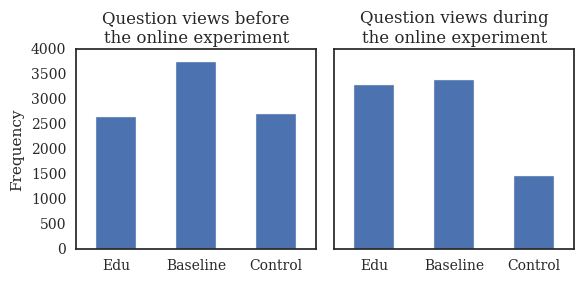

In [58]:
# read questions and filter columns
views_end = psql.read_sql("""
SELECT v.viewer_id, ab.ab_group_id, g.value AS ab_group FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id
JOIN ab_groups g ON g.id=ab.ab_group_id
JOIN questions q ON q.id=v.question_id
WHERE v.created_at >= '2016-11-14' AND v.created_at <= '2017-01-02' AND v.deleted=false AND q.category_id <> 2
""", connection)
views_start = psql.read_sql("""
SELECT v.viewer_id, ab.ab_group_id, g.value AS ab_group FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id
JOIN ab_groups g ON g.id=ab.ab_group_id
JOIN questions q ON q.id=v.question_id
WHERE v.created_at < '2016-11-14' AND v.created_at >= '2016-09-26' AND v.deleted=false AND q.category_id <> 2
""", connection)
print("Question views:")
print("\tbefore online experiment: \t%5.d" % views_start.shape[0])
print("\tduring online experiment: \t%5.d" % views_end.shape[0])


# Histogram views before
views_by_groups = views_start.groupby('ab_group')["viewer_id"].count()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,3))
views_by_groups.plot(kind="bar", ax = ax1, rot=0, title="Question views before\nthe online experiment")
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
ax1.set(xlabel='', ylabel='Frequency')

# Histogram views during
views_by_groups = views_end.groupby(['ab_group_id', 'ab_group'])["viewer_id"].count()

# title="Question views during online experiment"
views_by_groups.plot(kind="bar", ax=ax2, rot=0, title="Question views during\nthe online experiment")
ax2.set(xlabel='', ylabel='Frequency')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
fig.set_size_inches(6, 3)
fig.tight_layout()
fig.savefig('questions-views.eps', format='eps')

views_by_groups

### Comparing contributing users (answering, commenting) before the online experiment and during the online experiment.

,ab_group_id,ab_group,initiator_id
0,1,Question routing full,62
1,2,Question routing baseline,73
2,3,Control group for question routing,74


,,initiator_id
ab_group_id,ab_group,
1,Question routing full,40
2,Question routing baseline,26
3,Control group for question routing,28


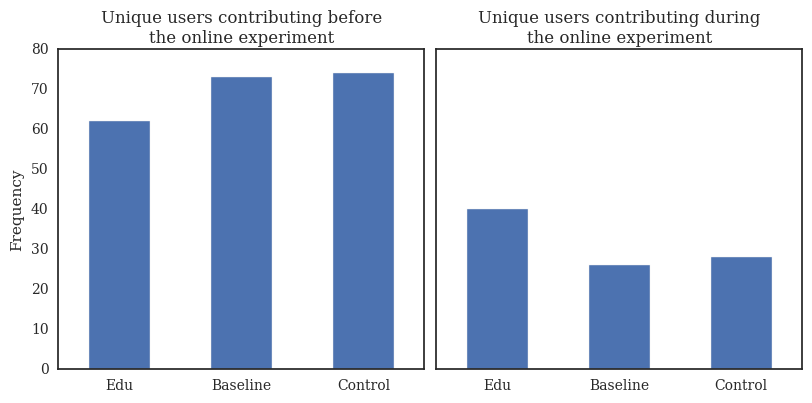

In [59]:
contributing_users_start = psql.read_sql("""
SELECT DISTINCT(a.initiator_id), ab.ab_group_id, g.value AS ab_group FROM activities a
JOIN ab_groupings ab ON ab.user_id=a.initiator_id
JOIN ab_groups g ON g.id=ab.ab_group_id
WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment', 'Shared::Vote', 'Shared::Watching')
AND a.created_at >= '2016-09-26' AND a.created_at < '2016-11-14'
    """, connection)

contributing_users_during = psql.read_sql("""
SELECT DISTINCT(a.initiator_id), ab.ab_group_id, g.value AS ab_group FROM activities a
JOIN ab_groupings ab ON ab.user_id=a.initiator_id
JOIN ab_groups g ON g.id=ab.ab_group_id
WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment', 'Shared::Vote', 'Shared::Watching')
AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02'
    """, connection)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
before = contributing_users_start.groupby(['ab_group_id', 'ab_group']).count()
display(before.reset_index())
before.plot(kind="bar", ax=ax1, title="Unique users contributing before\nthe online experiment", rot=0, legend=None)
ax1.set(xlabel='', ylabel='Frequency')
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
during = contributing_users_during.groupby(['ab_group_id', 'ab_group']).count()
display(during)
during.plot(kind="bar", ax=ax2, title="Unique users contributing during\nthe online experiment", rot=0, legend=None)
ax2.set(xlabel='', ylabel='Frequency')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
fig.tight_layout()
fig.set_size_inches(8, 4)

,ab_group_id,ab_group,initiator_id
0,1,Question routing full,233
1,2,Question routing baseline,237
2,3,Control group for question routing,215


,ab_group_id,ab_group,initiator_id
0,1,Question routing full,99
1,2,Question routing baseline,86
2,3,Control group for question routing,93


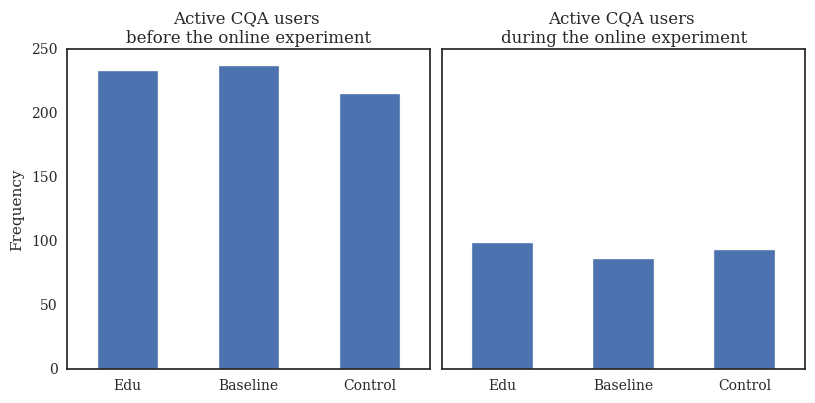

In [60]:
cqa_users_start = psql.read_sql("""
    SELECT DISTINCT(a.initiator_id), ab.ab_group_id, g.value AS ab_group FROM activities a
    JOIN ab_groupings ab ON ab.user_id=a.initiator_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE a.resource_type NOT IN ('Shared::List')
    AND a.created_at >= '2016-09-26' AND a.created_at < '2016-11-14'
    """, connection)
cqa_users_end = psql.read_sql("""
    SELECT DISTINCT(a.initiator_id), ab.ab_group_id, g.value AS ab_group FROM activities a
    JOIN ab_groupings ab ON ab.user_id=a.initiator_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE a.resource_type NOT IN ('Shared::List')
    AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02'
    """,connection)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
before = cqa_users_start.groupby(['ab_group_id', 'ab_group'])["initiator_id"].count()
display(before.reset_index())
before.plot(kind="bar", ax=ax1, title="Active CQA users \nbefore the online experiment", rot=0)
ax1.set(xlabel='', ylabel='Frequency')
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
during = cqa_users_end.groupby(['ab_group_id', 'ab_group'])["initiator_id"].count()
display(during.reset_index())
during.plot(kind="bar", ax=ax2, title="Active CQA users \nduring the online experiment", rot=0)
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
ax2.set(xlabel='', ylabel='Frequency')
fig.tight_layout()
fig.set_size_inches(8, 4)

In [61]:
# Load grades csv
grades = pd.read_csv('grades2.csv', na_values=['Not Attempted'])
# Active students before online experiment
grades_before = grades.filter(regex=("Email|Lab [1-5]:|Homework [1-5]:|Quizzes \d*: [1-5].*"))
grades_before.fillna(0, inplace=True)
mooc_active_before = grades_before[(grades_before.ix[:,1:].T != 0).any()]
print('Active students in MOOC who did any quizz, assignment or lab.')
print("\tbefore online experiment: \t%d" % mooc_active_before.shape[0])
# Active students durign online experiment
grades_after = grades.filter(regex=("Email|Lab ([6-9]{1}|\d\d):|Homework ([6-9]{1}|\d\d):|Quizzes \d*: ([6-9]{1}|\d\d).*"))
grades_after.fillna(0, inplace=True)
mooc_active_after = grades_after[(grades_after.ix[:,1:].T != 0).any()]
print("\tduring online experiment: \t%d" % mooc_active_after.shape[0])

users = psql.read_sql("""
    SELECT u.email, ab.user_id, ab.ab_group_id
    FROM users u
    JOIN ab_groupings ab ON ab.user_id=u.id""", connection)
users = pd.merge(users, ab_groups, on="ab_group_id")

# Join on users table
mooc_users_before = pd.merge(users, mooc_active_before, left_on='email', right_on='Email', how='right')
mooc_users_after = pd.merge(users, mooc_active_after, left_on='email', right_on='Email')

# Filter columns
mooc_users_before[['email','user_id','ab_group_id', 'ab_group']]
mooc_users_after[['email','user_id','ab_group_id', 'ab_group']]

display(mooc_users_before.groupby(['ab_group_id', 'ab_group'])["user_id"].count().reset_index())
display(mooc_users_after.groupby(['ab_group_id', 'ab_group'])["user_id"].count().reset_index())

mooc_users_grades = pd.merge(users, grades[['Grade','Email']], how='left',left_on='email', right_on='Email')
mooc_users_grades.fillna(0, inplace=True)
display(mooc_users_grades.groupby(['ab_group_id', 'ab_group'])["Grade"].agg({'mean_grade':'mean', 'std_grade':'std', 'grade_count':'count'}).reset_index())

Active students in MOOC who did any quizz, assignment or lab.
	before online experiment: 	726
	during online experiment: 	212


,ab_group_id,ab_group,user_id
0,1.0,Question routing full,208
1,2.0,Question routing baseline,211
2,3.0,Control group for question routing,218


,ab_group_id,ab_group,user_id
0,1,Question routing full,60
1,2,Question routing baseline,52
2,3,Control group for question routing,53


,ab_group_id,ab_group,grade_count,mean_grade,std_grade
0,1,Question routing full,1306,0.025773,0.119332
1,2,Question routing baseline,1306,0.022626,0.107509
2,3,Control group for question routing,1306,0.022489,0.103639


In [62]:
# Create before and during dataframe with answer, question and comments counts
# Before
# questions
question_by_groups = questions_start.groupby('ab_group_id')["author_id"].count()
start_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_start.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_start.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Interactions
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
contributing_users_by_groups = contributing_users_start.groupby(['ab_group_id', 'ab_group'])["initiator_id"].count()
temp = contributing_users_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Active users CQA
cqa_users_by_groups = cqa_users_start.groupby('ab_group_id')["initiator_id"].count()
temp = cqa_users_by_groups.to_frame(name = 'unique_users_using_CQA').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Users count - divided equally at the beggining
start_df = pd.merge(start_df, user_groups[['id','User count']], left_on='ab_group_id', right_on="id", how='inner')
# Active MOOC users
mooc_users_by_groups = mooc_users_before.groupby('ab_group_id')["user_id"].nunique()
temp = mooc_users_by_groups.to_frame(name = 'unique_users_mooc').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Views
views_by_groups = views_start.groupby('ab_group_id')["viewer_id"].count()
temp = views_by_groups.to_frame(name = 'views_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Votes
votes_by_groups = votes_start.groupby('ab_group_id')["voter_id"].count()
temp = votes_by_groups.to_frame(name = 'votes_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')

print("Statistics for groups before online experiment")
display(start_df[['ab_group', 'questions_count', 'answers_count', 'comments_count', 'interactions_count', 'unique_users_interacting', 'unique_users_mooc', 'unique_users_using_CQA', 'unique_users_contributing', 'User count', 'views_count', 'votes_count']])

# During
# questions
question_by_groups = questions_end.groupby('ab_group_id')["author_id"].count()
end_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_end.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_end.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# interactions
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
interactions_by_groups = contributing_users_during.groupby(['ab_group_id', 'ab_group'])["initiator_id"].count()
temp = interactions_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users CQA
cqa_users_by_groups = cqa_users_end.groupby('ab_group_id')["initiator_id"].count()
temp = cqa_users_by_groups.to_frame(name = 'unique_users_using_CQA').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Users count
end_df = pd.merge(end_df, user_groups[['id','User count']], left_on='ab_group_id', right_on="id", how='inner')
# Active MOOC users
mooc_users_by_groups = mooc_users_after.groupby('ab_group_id')["user_id"].nunique()
temp = mooc_users_by_groups.to_frame(name = 'unique_users_mooc').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Views
views_by_groups = views_end.groupby('ab_group_id')["viewer_id"].count()
temp = views_by_groups.to_frame(name = 'views_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Votes
votes_by_groups = votes_end.groupby('ab_group_id')["voter_id"].count()
temp = votes_by_groups.to_frame(name = 'votes_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')

print("Statistics for groups during online experiment")
display(end_df[['ab_group', 'questions_count', 'answers_count', 'comments_count', 'interactions_count', 'unique_users_interacting', 'unique_users_mooc', 'unique_users_using_CQA', 'unique_users_contributing', 'User count', 'views_count', 'votes_count']])

Statistics for groups before online experiment


,ab_group,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_mooc,unique_users_using_CQA,unique_users_contributing,User count,views_count,votes_count
0,Question routing full,60,74,92,19271,816,208,233,62,1306,2704,63
1,Question routing baseline,58,52,80,18773,812,211,237,73,1306,3742,71
2,Control group for question routing,47,61,106,17610,811,218,215,74,1306,2639,51


Statistics for groups during online experiment


,ab_group,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_mooc,unique_users_using_CQA,unique_users_contributing,User count,views_count,votes_count
0,Question routing full,47,91,95,31548,304,60,99,40,1306,3288,127
1,Question routing baseline,51,11,56,12788,278,52,86,26,1306,3393,73
2,Control group for question routing,18,44,24,14226,321,53,93,28,1306,1467,18


In [63]:
edu_remained_u = contributing_users_during[contributing_users_during['ab_group_id'] == 1]['initiator_id'].isin(contributing_users_start[contributing_users_start['ab_group_id'] == 1]['initiator_id'])
baseline_remained_u = contributing_users_during[contributing_users_during['ab_group_id'] == 2]['initiator_id'].isin(contributing_users_start[contributing_users_start['ab_group_id'] == 2]['initiator_id'])
control_remained_u = contributing_users_during[contributing_users_during['ab_group_id'] == 3]['initiator_id'].isin(contributing_users_start[contributing_users_start['ab_group_id'] == 3]['initiator_id'])

print("From users contributed before online experiment, how many continued to contribute during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(contributing_users_during[contributing_users_during['ab_group_id'] == 1][edu_remained_u]), len(contributing_users_start[contributing_users_start['ab_group_id'] == 1]), len(contributing_users_during[contributing_users_during['ab_group_id'] == 1][edu_remained_u])*100 / float(len(contributing_users_start[contributing_users_start['ab_group_id'] == 1]))))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(contributing_users_during[contributing_users_during['ab_group_id'] == 2][baseline_remained_u]), len(contributing_users_start[contributing_users_start['ab_group_id'] == 2]), len(contributing_users_during[contributing_users_during['ab_group_id'] == 2][baseline_remained_u])*100/ float(len(contributing_users_start[contributing_users_start['ab_group_id'] == 2]))))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(contributing_users_during[contributing_users_during['ab_group_id'] == 3][control_remained_u]), len(contributing_users_start[contributing_users_start['ab_group_id'] == 3]), len(contributing_users_during[contributing_users_during['ab_group_id'] == 3][control_remained_u])*100 / float(len(contributing_users_start[contributing_users_start['ab_group_id'] == 3]))))

edu_cont_interacting_u = interaction_end[interaction_end['ab_group_id'] == 1]['lister_id'].isin(interaction_start[interaction_start['ab_group_id'] == 1]['lister_id'])
baseline__cont_interacting_u = interaction_end[interaction_end['ab_group_id'] == 2]['lister_id'].isin(interaction_start[interaction_start['ab_group_id'] == 2]['lister_id'])
control_cont_interacting_u = interaction_end[interaction_end['ab_group_id'] == 3]['lister_id'].isin(interaction_start[interaction_start['ab_group_id'] == 3]['lister_id'])
print("From users interacting with the course before online experiment, how many continued interacting with the course during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(interaction_end[interaction_end['ab_group_id'] == 1][edu_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first')), start_df[start_df['ab_group_id'] == 1]['unique_users_interacting'], len(interaction_end[interaction_end['ab_group_id'] == 1][edu_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 1]['unique_users_interacting']) ))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(interaction_end[interaction_end['ab_group_id'] == 2][baseline__cont_interacting_u].drop_duplicates(subset='lister_id', keep='first')), start_df[start_df['ab_group_id'] == 2]['unique_users_interacting'], len(interaction_end[interaction_end['ab_group_id'] == 2][baseline__cont_interacting_u].drop_duplicates(subset='lister_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 2]['unique_users_interacting']) ))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(interaction_end[interaction_end['ab_group_id'] == 3][control_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first')), start_df[start_df['ab_group_id'] == 3]['unique_users_interacting'], len(interaction_end[interaction_end['ab_group_id'] == 3][control_cont_interacting_u].drop_duplicates(subset='lister_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 3]['unique_users_interacting']) ))

edu_cont_cqa_u = views_end[views_end['ab_group_id'] == 1]['viewer_id'].isin(views_start[views_start['ab_group_id'] == 1]['viewer_id'])
baseline__cont_cqa_u = views_end[views_end['ab_group_id'] == 2]['viewer_id'].isin(views_start[views_start['ab_group_id'] == 2]['viewer_id'])
control_cont_cqa_u = views_end[views_end['ab_group_id'] == 3]['viewer_id'].isin(views_start[views_start['ab_group_id'] == 3]['viewer_id'])
print("From users using CQA system before online experiment, how many continued using CQA system during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(views_end[views_end['ab_group_id'] == 1][edu_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first')), start_df[start_df['ab_group_id'] == 1]['unique_users_using_CQA'], len(views_end[views_end['ab_group_id'] == 1][edu_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 1]['unique_users_using_CQA']) ))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(views_end[views_end['ab_group_id'] == 2][baseline__cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first')), start_df[start_df['ab_group_id'] == 2]['unique_users_using_CQA'], len(views_end[views_end['ab_group_id'] == 2][baseline__cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 2]['unique_users_using_CQA']) ))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(views_end[views_end['ab_group_id'] == 3][control_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first')), start_df[start_df['ab_group_id'] == 3]['unique_users_using_CQA'], len(views_end[views_end['ab_group_id'] == 3][control_cont_cqa_u].drop_duplicates(subset='viewer_id', keep='first'))*100 / float(start_df[start_df['ab_group_id'] == 3]['unique_users_using_CQA']) ))

From users contributed before online experiment, how many continued to contribute during online experiment:
	 Recommendation with educational context: 	22 from 62 	= 35.48%
	 Baseline recommendation: 			15 from 73 	= 20.55%
	 Control group: 				14 from 74 	= 18.92%
From users interacting with the course before online experiment, how many continued interacting with the course during online experiment:
	 Recommendation with educational context: 	272 from 816 	= 33.33%
	 Baseline recommendation: 			248 from 812 	= 30.54%
	 Control group: 				274 from 811 	= 33.79%
From users using CQA system before online experiment, how many continued using CQA system during online experiment:
	 Recommendation with educational context: 	64 from 233 	= 27.47%
	 Baseline recommendation: 			62 from 237 	= 26.16%
	 Control group: 				50 from 215 	= 23.26%


Users interacting with the course decreased during the online course. The course got harder and it is typical pattern present in the MOOC courses.

Control group has highest percentage of new contributors who did not contribute before online experiment, which is not according to our hypothesis.

## Average counts per active MOOC user
Active MOOC user is a user with any activity in the MOOC course during a period.

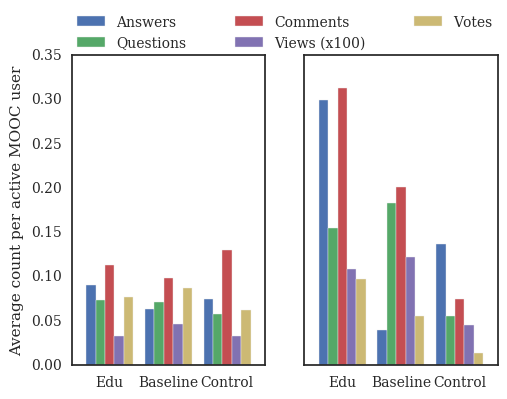

In [64]:
# Normalization by number of active users
start_df['questions_count_per_user']= start_df['questions_count'] / start_df['unique_users_interacting']
start_df['answers_count_per_user']= start_df['answers_count'] / start_df['unique_users_interacting']
start_df['comments_count_per_user']= start_df['comments_count'] / start_df['unique_users_interacting']
start_df['users_contributing_per_user']= start_df['unique_users_contributing'] / start_df['unique_users_interacting']
start_df['interactions_count_per_user']= start_df['interactions_count'] / (1000*start_df['unique_users_interacting'])
start_df['views_count_per_user']= start_df['views_count'] / (100*start_df['unique_users_interacting'])
start_df['votes_count_per_user']= start_df['votes_count'] / start_df['unique_users_interacting']

end_df['questions_count_per_user']= end_df['questions_count'] / end_df['unique_users_interacting']
end_df['answers_count_per_user']= end_df['answers_count'] / end_df['unique_users_interacting']
end_df['comments_count_per_user']= end_df['comments_count'] / end_df['unique_users_interacting']
end_df['users_contributing_per_user']= end_df['unique_users_contributing'] / end_df['unique_users_interacting']
end_df['interactions_count_per_user']= end_df['interactions_count'] / (1000*end_df['unique_users_interacting'])
end_df['views_count_per_user']= end_df['views_count'] / (100*end_df['unique_users_interacting'])
end_df['votes_count_per_user']= end_df['votes_count'] / end_df['User count']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
start_df.groupby(['ab_group_id', 'ab_group'])["answers_count_per_user", "questions_count_per_user", "comments_count_per_user", "views_count_per_user", "votes_count_per_user"].sum()\
    .plot(kind="bar", ax=ax1, rot=0, legend=None, width=0.8)
ax1.set(xlabel='', ylabel='Average count per active MOOC user')
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
#handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, ["Answers","Questions","Comments"], loc='upper right')

end_df.groupby(['ab_group_id', 'ab_group'])["answers_count_per_user", "questions_count_per_user", "comments_count_per_user", "views_count_per_user", "votes_count_per_user"].sum()\
    .plot(kind="bar", ax=ax2, rot=0, width=0.8)
ax2.set(xlabel='', ylabel='')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, ["Answers","Questions","Comments"], loc='upper right')
ax2.legend(handles, ["Answers","Questions","Comments", "Views (x100)", "Votes"], bbox_to_anchor=(-1.2, 1.0, 2.2, .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
fig.set_size_inches(5.5, 4.)
fig.savefig('average-counts.eps', format='eps')

**Question recommendation with educational context clearly outperformed baseline approach in average count of answers, comments and voting.** However, baseline group got better results in average count of questions and views.

By considering number of contributing users one can see that question recommendation with educational context involved more unique users into contributing compared to the baseline and control group. (Table above)

Baseline question recommendation has highest number of asked questions.

**Question recommendation has more contributions in comparison to control group without recommendation.** We consider contribution to question answering by either answering, asking or commenting a question. 

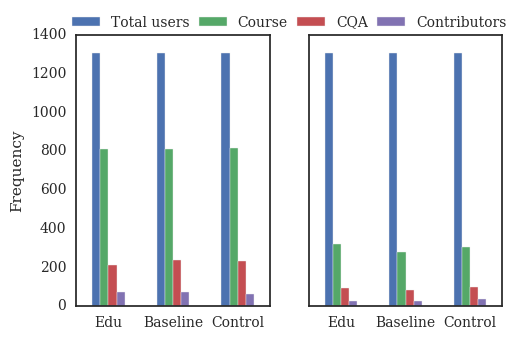

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
start_df.groupby('ab_group')["User count", "unique_users_interacting", "unique_users_using_CQA", "unique_users_contributing"].sum()\
    .plot(kind="bar", ax=ax1, rot=0, legend=None)
ax1.set(xlabel='', ylabel='Frequency')
ax1.set_xticklabels(["Edu", "Baseline", "Control"])
#handles, labels = ax1.get_legend_handles_labels()
#ax1.legend(handles, ["Total","Course","CQA"], loc='upper left')

end_df.groupby('ab_group')["User count","unique_users_interacting", "unique_users_using_CQA", "unique_users_contributing"].sum()\
    .plot(kind="bar", ax=ax2, rot=0)
ax2.set(xlabel='', ylabel='')
ax2.set_xticklabels(["Edu", "Baseline", "Control"])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, ["Total users","Course","CQA","Contributors"], bbox_to_anchor=(-1.25, 1.0, 2.3, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
fig.set_size_inches(5.5, 3.5)
fig.savefig('active-users.eps', format='eps')

,ab_group,unique_users_using_CQA
0,Question routing full,99
1,Question routing baseline,86
2,Control group for question routing,93


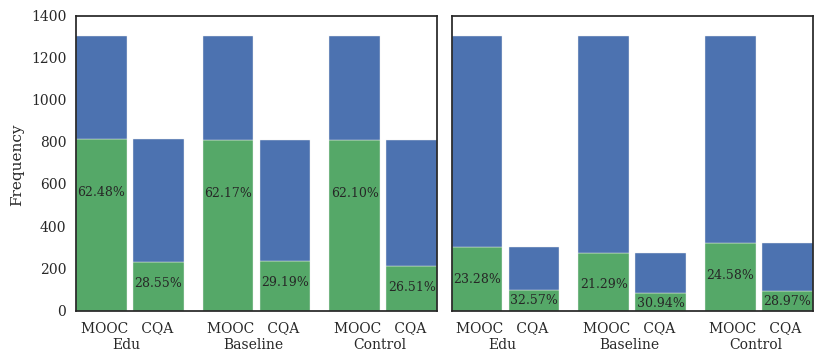

In [66]:
#start_df.groupby('ab_group')[['ab_group','unique_users_mooc', 'unique_users_using_CQA' ,'User count']].sum().plot(kind='bar', stacked=True)
#start_df.groupby('ab_group')['unique_users_mooc', 'User count'].unstack().plot.bar(stacked=True)
display(end_df[['ab_group', 'unique_users_using_CQA']])
# Create a figure with a single subplot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
bar_width = 1
bar_1 = [0,1,2]
bar_2 = [0.45,1.45,2.45]
tick_pos = [i+0.4 for i in bar_1]
plt.setp((ax1,ax2), xticks=tick_pos, xticklabels=['MOOC   CQA\nEdu','MOOC   CQA\nBaseline','MOOC   CQA\nControl'], ylabel="Frequency")
plt.ylabel("")
ax1.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)
ax1.bar(bar_1,
       start_df['unique_users_interacting'],
       color=sns.color_palette()[1],
       width=0.4,
       )
ax1.bar(bar_1,
       start_df['User count']-start_df['unique_users_interacting'],
       bottom=start_df['unique_users_interacting'],
       color=sns.color_palette()[0],
       width=0.4,
       )
ax1.bar(bar_2,
       start_df['unique_users_using_CQA'],
       color=sns.color_palette()[1],
       width=0.4,
       )
mid_df = start_df['unique_users_interacting']-start_df['unique_users_using_CQA']
ax1.bar(bar_2,
       mid_df,
       bottom=start_df['unique_users_using_CQA'],
       color=sns.color_palette()[0],
       width=0.4
       )
### After
ax2.bar(bar_1,
       end_df['unique_users_interacting'],
       color=sns.color_palette()[1],
       width=0.4
       )
# mid_df = start_df['unique_users_interacting']-end_df['unique_users_interacting']
# ax2.bar(bar_1,
#        mid_df,
#        bottom=end_df['unique_users_interacting'],
#        color=sns.color_palette()[2],
#        width=0.4,
#        )
ax2.bar(bar_1,
       end_df['User count']-end_df['unique_users_interacting'],
       #bottom=[i+j for i,j in zip(end_df['unique_users_interacting'], mid_df)],
       bottom=end_df['unique_users_interacting'],
       color=sns.color_palette()[0],
       width=0.4
       )
ax2.bar(bar_2,
       end_df['unique_users_using_CQA'],
       color=sns.color_palette()[1],
       width=0.4
       )
#mid_df = start_df['unique_users_using_CQA']-end_df['unique_users_using_CQA']
mid_df = end_df['unique_users_interacting']-end_df['unique_users_using_CQA']
ax2.bar(bar_2,
       mid_df,
       bottom=end_df['unique_users_using_CQA'],
       color=sns.color_palette()[0],
       width=0.4
       )
# ax2.bar(bar_2,
#        end_df['User count']-end_df['unique_users_interacting'],
#        bottom=[i+j for i,j in zip(end_df['unique_users_using_CQA'], mid_df)],
#        #bottom=end_df['unique_users_using_CQA'],
#        color=sns.color_palette()[0],
#        width=0.4
#        )

mooc_dropout_rate = 1-(end_df['unique_users_interacting'] / start_df['unique_users_interacting'])
cqa_dropout_rate = 1-(end_df['unique_users_using_CQA'] / start_df['unique_users_using_CQA'])
for i in range(3):
    ax1.text(bar_1[i]+0.2, start_df['unique_users_interacting'][i]-250, "%.2f%%" % (start_df['unique_users_interacting'][i]*100/float(start_df['User count'][i])), ha='center',va='center', fontsize=9)
    ax1.text(bar_2[i]+0.2, start_df['unique_users_using_CQA'][i]-100, "%.2f%%" % (start_df['unique_users_using_CQA'][i]*100/float(start_df['unique_users_interacting'][i])), ha='center',va='center', fontsize=9)
    ax2.text(bar_1[i]+0.2, end_df['unique_users_interacting'][i]-150, "%.2f%%" % (end_df['unique_users_interacting'][i]*100/float(end_df['User count'][i])), ha='center',va='center', fontsize=9)
    ax2.text(bar_2[i]+0.2, end_df['unique_users_using_CQA'][i]-45, "%.2f%%" % (end_df['unique_users_using_CQA'][i]*100/float(end_df['unique_users_interacting'][i])), ha='center',va='center', fontsize=9)
    #ax2.text(bar_1[i]+0.2, end_df['unique_users_interacting'][i]+250, "%.2f%%" % (mooc_dropout_rate[i]*100), ha='center',va='center', fontsize=9)
    #ax2.text(bar_2[i]+0.2, end_df['unique_users_using_CQA'][i]+70, "%.2f%%" % (cqa_dropout_rate[i]*100), ha='center',va='center', fontsize=9)

fig.tight_layout()
fig.set_size_inches(8.2, 3.5)
fig.savefig('users-counts.svg', format='svg')


### Question recommendation lowered instructors load by 6%
Answering and commenting is considered.

In [67]:
teachers_before = psql.read_sql("""
SELECT sum(case when author_id in (select user_id from assignments where role_id = 2) then 1 else 0 end) / cast(count(*) as float) as count
from (
select author_id from answers where deleted=false and question_id in (select id from questions where category_id <> 2 AND created_at < '2016-11-14' AND created_at >= '2016-09-26' AND deleted=false)
union all
select author_id from comments where commentable_type ='Shared::Question' and deleted=false and commentable_id in (select id from questions where category_id <> 2 AND created_at < '2016-11-14' AND created_at >= '2016-09-26' AND deleted=false)
union all
select author_id from comments where commentable_type ='Shared::Answer' and deleted=false and commentable_id in (select id from answers where question_id in (select id from questions where category_id <> 2 AND created_at < '2016-11-14' AND created_at >= '2016-09-26' AND deleted=false))
) as a
""", connection)
teachers_during = psql.read_sql("""
select sum(case when author_id in (select user_id from assignments where role_id = 2) then 1 else 0 end) / cast(count(*) as float) as count
from (
select author_id from answers where deleted=false and question_id in (select id from questions where category_id <> 2 AND created_at >= '2016-11-14' AND created_at <= '2017-01-02' AND deleted=false)
union all
select author_id from comments where commentable_type ='Shared::Question' and deleted=false and commentable_id in (select id from questions where category_id <> 2 AND created_at >= '2016-11-14' AND created_at <= '2017-01-02' AND deleted=false)
union all
select author_id from comments where commentable_type ='Shared::Answer' and deleted=false and commentable_id in (select id from answers where question_id in (select id from questions where category_id <> 2 AND created_at >= '2016-11-14' AND created_at <= '2017-01-02' AND deleted=false))
) as b
""", connection)
print("Teaching staff contributions compared to all contributions:")
print("\tbefore online experiment: \t%.2f%%" % (teachers_before['count']*100))
print("\tduring online experiment: \t%.2f%%" % (teachers_during['count']*100))
print("\tdifference: \t\t\t%.2f%%" % (teachers_before['count']*100 - teachers_during['count']*100))

Teaching staff contributions compared to all contributions:
	before online experiment: 	37.28%
	during online experiment: 	31.25%
	difference: 			6.03%


### How educational specific features helps in recommendation

Educational specific features (used only by 1. Educational context recommendation method) displayed are grades and average course acitivity. Knowledge is the sum of number of answers, comments and earned votes. 

Grades, knowledge and average course activity represents values at the end of the course.

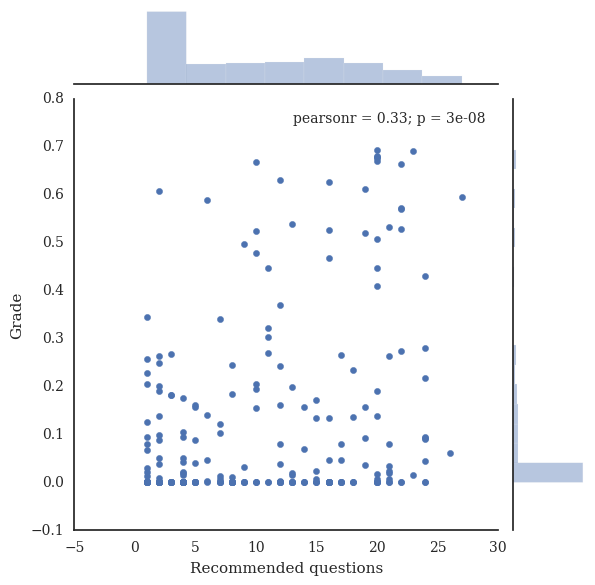

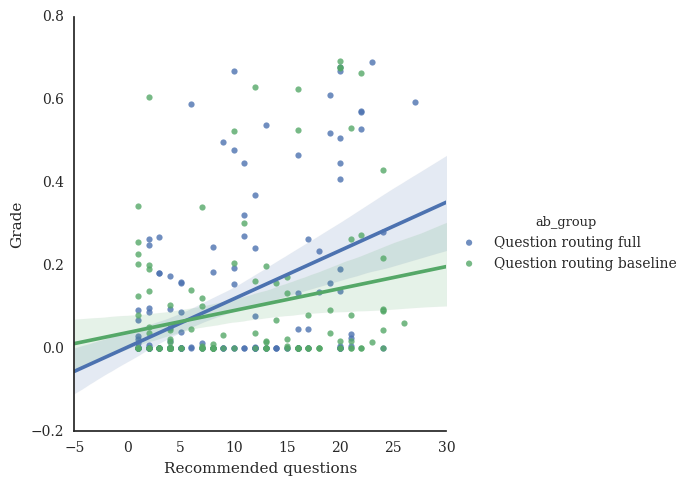

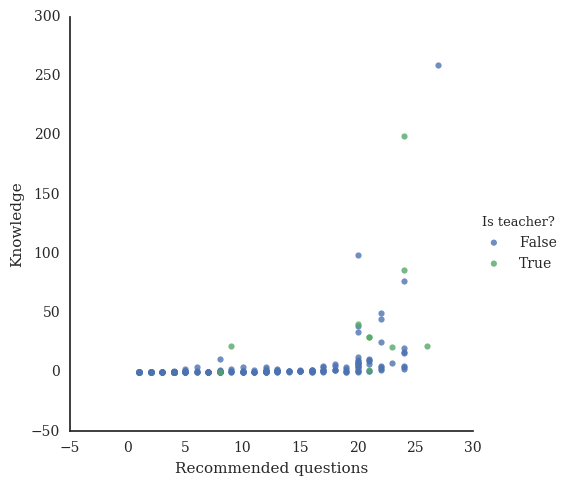

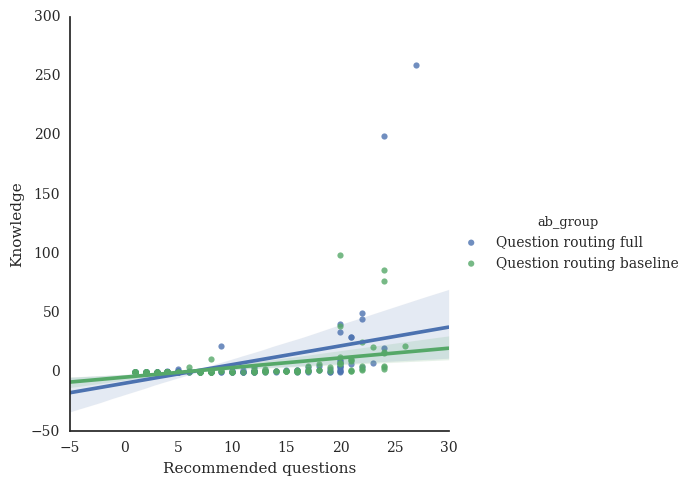

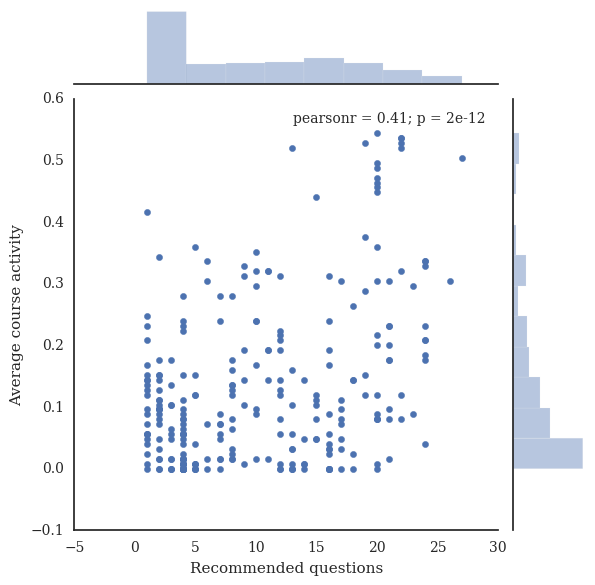

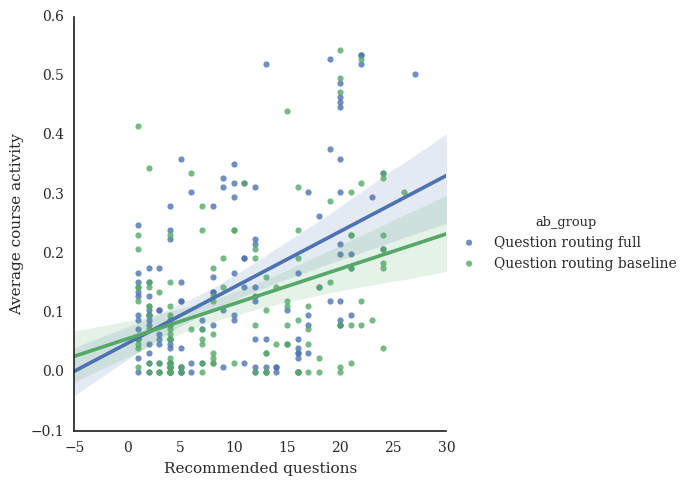

In [68]:
# Grade and number of rec
grades = psql.read_sql("""
    SELECT ab.user_id, g.value AS "ab_group", COUNT(n.id) as "Recommended questions", COALESCE(up.value, 0) AS "Grade" 
    FROM notifications as n
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='Grade')
    WHERE n.action = 'recommendation'
    GROUP BY ab.user_id, g.id, up.value
""", connection)
sns.jointplot(x="Recommended questions", y="Grade", data=grades)
sns.lmplot(x="Recommended questions", y="Grade", hue="ab_group", data=grades, fit_reg=True)

knowledge = psql.read_sql("""
    SELECT ab.user_id, g.value AS "ab_group", COUNT(n.id) as "Recommended questions", COALESCE(up.value, 0) AS "Knowledge", exists (select true from assignments where user_id=ab.user_id) AS "Is teacher?"
    FROM notifications as n
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='Knowledge')
    WHERE n.action = 'recommendation'
    GROUP BY ab.user_id, g.id, up.value
    """, connection)
sns.lmplot(x="Recommended questions", y="Knowledge", hue="Is teacher?", data=knowledge, fit_reg=False)
sns.lmplot(x="Recommended questions", y="Knowledge", hue="ab_group", data=knowledge)

avg_course_activity = psql.read_sql("""
SELECT ab.user_id, g.value AS "ab_group", COUNT(n.id) as "Recommended questions", COALESCE(up.value, 0) AS "Average course activity" 
FROM notifications as n
JOIN ab_groupings ab ON ab.user_id = n.recipient_id
JOIN ab_groups g ON g.id=ab.ab_group_id
LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='AvgCourseActivity')
WHERE n.action = 'recommendation'
GROUP BY ab.user_id, g.id, up.value
ORDER BY g.id
    """, connection)
sns.jointplot(x="Recommended questions", y="Average course activity", data=avg_course_activity)
sns.lmplot(x="Recommended questions", y="Average course activity", hue="ab_group", data=avg_course_activity)

### Student examples of how features are related to number of recommended questions

In [69]:
students_examples = psql.read_sql("""
    SELECT DISTINCT ab.user_id, ab.ab_group_id, COUNT(n.id) as "Number of recommended questions", property, value
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN user_profiles up ON (up.user_id = ab.user_id)
    WHERE n.action = 'recommendation' AND up.targetable_id = -1
    AND ab.user_id IN (2298, 1771)
    GROUP BY ab.ab_group_id, ab.user_id, property, value
    ORDER BY ab.user_id
""", connection)
display(students_examples.ix[:2])
students_examples.ix[4:13]

,user_id,ab_group_id,Number of recommended questions,property,value
0,1771,1,8,AvgCourseActivity,0.16000
1,1771,1,8,AvgCqaActivity,0.06400
2,1771,1,8,Grade,0.24459


,user_id,ab_group_id,Number of recommended questions,property,value
4,2298,1,20,AnswersVotesCount,1.00000
5,2298,1,20,AvgCourseActivity,0.45600
6,2298,1,20,AvgCqaActivity,0.21600
7,2298,1,20,Grade,0.67975
8,2298,1,20,Knowledge,1.00000
9,2298,1,20,QuestionCount,2.00000
10,2298,1,20,QuestionVotesCount,1.00000
11,2298,1,20,RegistrationDate,NaN


In the tables above are interesting examples of two students from groups with educational specific recommendation (ab_group_id = 1). 

Student 2298 had only two contribution in the CQA system, i.e. two questions. However, educational specific question recommendation routed 20 questions to him/her as his/her average activity in course and grades are high. Moreover, in our analysis we discovered that this student is from TU Delft and did this course as a part of his university studies.

Student 1771 had no contribution in the CQA system. Question recommendation routed only 8 questions to him/her based on the average activity in course and grade.

Without considering non-QA specific features from the course, these users would not be ranked as experts and fewer questions would be recommended to them. However, student 2298 were not willing to share his/her knowledge.

### Knowledge gap is positive in overall (median = 7) i.e. answerers have higher knowledge than askers 
Knowledge gaps data sets are created by Askalot evaluation infrastructure because the knowledge gap between asker of the question and answerer was changing over time.

count    378.000000
mean      18.039683
std       44.959410
min     -167.000000
25%        0.000000
50%        7.000000
75%       34.750000
max      166.000000
Name: Knowledge gap, dtype: float64

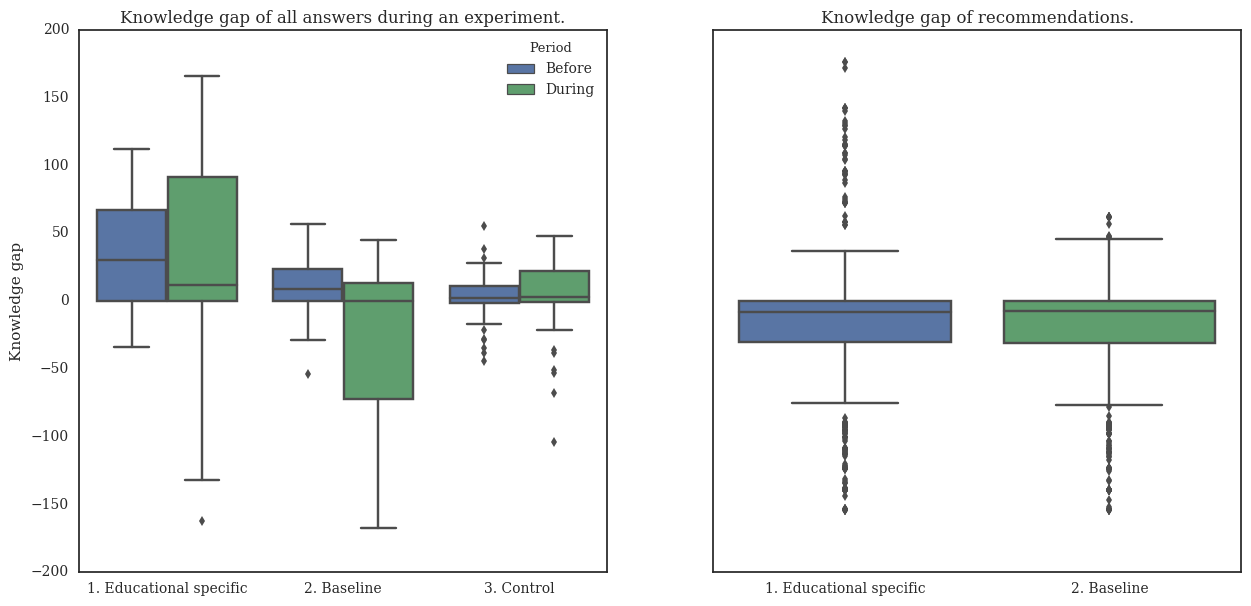

In [70]:
kgaps = pd.read_csv('data/full/kgaps.txt', delimiter=' ', header=None, names = ['Answerer ab_group', 'Knowledge gap', 'Period'])
kgaps['Period'] = np.where(kgaps['Period'] == 1, 'During', 'Before')
kgaps['Answerer ab_group'].replace({1:'1. Educational specific',2:'2. Baseline', 3:'3. Control'},inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,7))
sns.boxplot(x="Answerer ab_group", y="Knowledge gap", hue="Period", data=kgaps, ax=ax1, order=["1. Educational specific", "2. Baseline", "3. Control"])
ax1.set_title('Knowledge gap of all answers during an experiment.')
ax1.set(xlabel='', ylabel='Knowledge gap')

kgaps_rec = pd.read_csv('data/full/rec_kgaps.txt', delimiter=' ', header=None, names = ['Answerer ab_group', 'Knowledge gap', 'Period'])
kgaps_rec['Answerer ab_group'].replace({1:'1. Educational specific',2:'2. Baseline', 3:'3. Control'},inplace=True)
sns.boxplot(x="Answerer ab_group", y="Knowledge gap", data=kgaps_rec, ax=ax2, order=["1. Educational specific", "2. Baseline"])
ax2.set_title('Knowledge gap of recommendations.')
ax2.set(xlabel='', ylabel='')

kgaps["Knowledge gap"].describe()

## Online experiment had lower question answering success rate
Question answering success rate is number of questions with at least one answer.

Note: Only questions are considered, not discussions and bug reports.

In [71]:
questions_before = psql.read_sql("""
select sum(case when q.best_answer > 0 then 1 else 0 end)/CAST(count(*) as float) as best_answer_ratio,
sum(case when q.answer > 0 then 1 else 0 end)/CAST(count(*) as float) as question_answer_success_ratio
FROM (
    select q.id AS "Number of questions",
                 sum(case when ba.id is not null then 1 else 0 end) as best_answer,
                 sum(case when a.id is not null then 1 else 0 end) as answer

    from questions q 
    LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at < q.created_at + INTERVAL '30 day' AND a.deleted=false)
    LEFT JOIN answers ba ON (ba.question_id=q.id AND ba.created_at < q.created_at + INTERVAL '30 day'  AND ba.deleted=false and ba.id in (select answer_id from labelings where q.deleted=false))

    where q.category_id <> 2 AND q.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false AND question_type_id = 1 
    group by q.id
) q
            """,connection)

questions_during = psql.read_sql("""
select sum(case when q.best_answer > 0 then 1 else 0 end)/CAST(count(*) as float) as best_answer_ratio,
sum(case when q.answer > 0 then 1 else 0 end)/CAST(count(*) as float) as question_answer_success_ratio

FROM (
    select q.id AS "Number of questions",
                 sum(case when ba.id is not null then 1 else 0 end) as best_answer,
                 sum(case when a.id is not null then 1 else 0 end) as answer

    from questions q 
    LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at < q.created_at + INTERVAL '30 day' AND a.deleted=false)
    LEFT JOIN answers ba ON (ba.question_id=q.id AND ba.created_at < q.created_at + INTERVAL '30 day' AND ba.deleted=false and ba.id in (select answer_id from labelings where q.deleted=false))

    where q.category_id <> 2 AND q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false AND question_type_id = 1 
    group by q.id
) q
""",connection)
print("Before:")
display(questions_before)
print("During:")
display(questions_during)

Before:


,best_answer_ratio,question_answer_success_ratio
0,0.221154,0.884615


During:


,best_answer_ratio,question_answer_success_ratio
0,0.144737,0.842105


### Average answer quality was preserved with the question recommendation
Quality of answers is estimated by number of earned votes for a particular answer.

In [72]:
quality = psql.read_sql("""
            SELECT (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26' AND a.deleted=false
            AND q.category_id <> 2) 
            as quality_before, 
            (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02' AND a.deleted=false
            AND q.category_id <> 2)
            as quality_during
          """, connection)
quality

,quality_before,quality_during
0,0.452514,0.56


### Average time to answer increased with a recommendation

In [73]:
before_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26')
            WHERE q.created_at < '2016-11-14' AND q.created_at >= '2016-09-26' AND q.deleted=false
            GROUP BY q.id
            """,connection)

during_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02')
            WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false
            GROUP BY q.id
            """,connection)

print("Average time to answer:")
avg_time_before = (before_answers_time['first_answer_time'] - before_answers_time['created_at']).sum() / len(before_answers_time) 
print("\tbefore online experiment: %s" % avg_time_before)
avg_time_during = (during_answers_time['first_answer_time'] - during_answers_time['created_at']).sum() / len(during_answers_time)
print("\tduring online experiment: %s" % avg_time_during)
print("Average time to answer increased with question recommendation by: %s" % (avg_time_during - avg_time_before))

Average time to answer:
	before online experiment: 0 days 19:50:10.427213
	during online experiment: 1 days 14:23:39.805178
Average time to answer increased with question recommendation by: 0 days 18:33:29.377964


Average time to answer increased during the online experiment. However, it might be related with higher difficulty of the course and less number of active users.

### Contributing users for each week compared to active users in a week did not change
Contribution is defined as asking, answering and commenting. Active user is a user who saw any question during a particular week.

,weekly,Contributing users,Active users,Contributing to active portion
0,2016-09-26 00:00:00+02:00,16,136,11.764706
1,2016-10-03 00:00:00+02:00,19,145,13.103448
2,2016-10-10 00:00:00+02:00,51,1661,3.070439
3,2016-10-17 00:00:00+02:00,52,919,5.658324
4,2016-10-24 00:00:00+02:00,36,730,4.931507
5,2016-10-31 00:00:00+01:00,26,614,4.234528
6,2016-11-07 00:00:00+01:00,21,513,4.093567


,weekly,Contributing users,Active users,Contributing to active portion
6,2016-11-07 00:00:00+01:00,21,513,4.093567
7,2016-11-14 00:00:00+01:00,23,535,4.299065
8,2016-11-21 00:00:00+01:00,27,478,5.648536
9,2016-11-28 00:00:00+01:00,23,617,3.727715
10,2016-12-05 00:00:00+01:00,21,463,4.535637
11,2016-12-12 00:00:00+01:00,31,545,5.688073
12,2016-12-19 00:00:00+01:00,19,343,5.539359
13,2016-12-26 00:00:00+01:00,8,220,3.636364


Recommendation effect size: -1.554


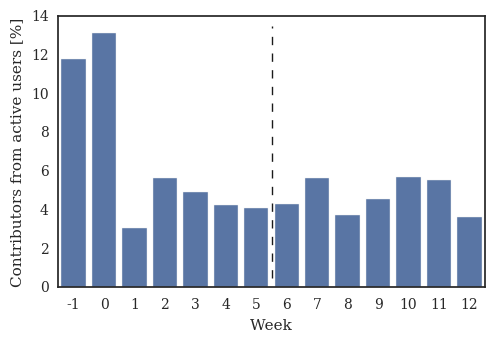

In [74]:
contributing_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Contributing users"
    FROM activities a
    LEFT OUTER JOIN questions q ON (q.id=a.resource_id AND a.resource_type='Shared::Question')
    LEFT OUTER JOIN answers ans ON (ans.id=a.resource_id AND a.resource_type='Shared::Answer')
    LEFT OUTER JOIN questions qa ON (qa.id=ans.question_id AND a.resource_type='Shared::Answer')
    WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment')
    AND a.created_at > '2016-09-26' AND a.created_at < '2017-01-01' AND a.action='create'
    AND (q.category_id <> 2 OR q.category_id IS NULL) AND (qa.category_id <> 2 OR qa.category_id IS NULL)
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
active_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Active users" 
    FROM activities a
    WHERE a.created_at > '2016-09-26' AND a.created_at < '2017-01-01' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
users = pd.merge(contributing_users, active_users, on='weekly', how='inner')
users['Contributing to active portion'] = users['Contributing users']*100 / users['Active users']
display(users.ix[:6])
display(users.ix[6:])

print("Recommendation effect size: %.3f" % (users.ix[6:]['Contributing to active portion'].mean() - users.ix[1:5]['Contributing to active portion'].mean()))

fig = plt.figure()
ax= sns.barplot(y='Contributing to active portion', x=np.arange(-1,13), data=users, color=sns.color_palette()[0])
ax.vlines(6.5, 0.5, 13.5, linestyle='--', linewidth=1)
ax.set(xlabel='Week', ylabel='Contributors from active users [%]')
fig.set_size_inches(5.5, 3.5)
fig.savefig('course-contributing-activity.eps', format='eps')

Note: We deployed tracking of course topic views from 1. week which makes first 2 columns incorrect.

## Statistical tests for answer quality and time to first answer

In [75]:
df = psql.read_sql("""
SELECT a.votes_difference, (a.created_at - q.created_at) as "time to answer", ab.ab_group_id, g.value as "ab_group"
FROM questions q
JOIN (  SELECT id, author_id, question_id, votes_difference, created_at, rank() OVER ( 
        PARTITION BY question_id ORDER BY created_at ASC) FROM answers
) AS a ON (a.question_id=q.id AND a.rank = 1 AND a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02')
JOIN ab_groupings ab ON a.author_id=ab.user_id
JOIN ab_groups g ON g.id=ab.ab_group_id
WHERE q.created_at >= '2016-11-14' AND q.created_at <= '2017-01-02' AND q.deleted=false
    """, connection)
df['time to answer'] = df['time to answer'].astype('timedelta64[h]')

edu_group = df[df['ab_group_id'] == 1].copy().reset_index()
baseline_rec_group = df[df['ab_group_id'] == 2].copy().reset_index()
control_group = df[df['ab_group_id'] == 3].copy().reset_index()

print("Counts: \t\tEducational %d \t\tBaseline %d \t\t\tControl %d" % (edu_group['votes_difference'].count(), baseline_rec_group['votes_difference'].count(), control_group['votes_difference'].count()))
print("Votes difference: \tEducational (M=%.3f,SD=%.3f) \tBaseline (M=%.3f,SD=%.3f)\tControl (M=%.3f,SD=%.3f)" % (edu_group['votes_difference'].mean(), edu_group['votes_difference'].std(), baseline_rec_group['votes_difference'].mean(), baseline_rec_group['votes_difference'].std(),  control_group['votes_difference'].mean(), control_group['votes_difference'].std()))
print("Time to answer difference[in hours]: \tEducational (M=%.3f,SD=%.3f)  \tBaseline (M=%.3f,SD=%.3f)\tControl (M=%.3f,SD=%.3f) " % (edu_group['time to answer'].mean(),edu_group['time to answer'].std(),  baseline_rec_group['time to answer'].mean(), baseline_rec_group['time to answer'].std(), control_group['time to answer'].mean(), control_group['time to answer'].std()))

display(stats.ttest_ind(edu_group['votes_difference'], control_group['votes_difference'], equal_var=False))
display(stats.ttest_ind(edu_group['time to answer'], control_group['time to answer'], equal_var=False))
#display(stats.f_oneway(edu_group['votes_difference'], baseline_rec_group['votes_difference'], control_group['votes_difference']))
#len(baseline_rec_group)

display(weightstats.ttost_ind(edu_group['votes_difference'], control_group['votes_difference'], -0.6, 0.6))
display(weightstats.ttost_ind(edu_group['time to answer'], control_group['time to answer'], -40, 40))

group_time_diff = edu_group['time to answer'] -control_group['time to answer']
print(group_time_diff.mean())
print(group_time_diff.std())

Counts: 		Educational 66 		Baseline 7 			Control 28
Votes difference: 	Educational (M=0.470,SD=0.948) 	Baseline (M=0.143,SD=0.378)	Control (M=0.286,SD=0.659)
Time to answer difference[in hours]: 	Educational (M=32.727,SD=43.613)  	Baseline (M=32.571,SD=29.205)	Control (M=52.714,SD=63.151) 


Ttest_indResult(statistic=1.0782047134636026, pvalue=0.28453297669045996)

Ttest_indResult(statistic=-1.527339895261359, pvalue=0.1348767910829812)

(0.018682507203582631,
 (3.9807253372495626, 6.8527293834439815e-05, 92.0),
 (-2.1123561839297786, 0.018682507203582631, 92.0))

(0.040046821585310408,
 (1.7696807372113978, 0.040046821585310408, 92.0),
 (-5.3044486211417574, 3.8736107106221649e-07, 92.0))

-25.4285714286
63.2897092866


Educational group comparing to control group. 
- Answer quality was preserved during online experiment.
- Time to answer is significantly better in educational group.

Note: Only first answer for a question is considered.

## Contributors dropout rate
Users who contributed before online experiment and drop from using CQA system during online experiment.

In [76]:
overall_droupout = psql.read_sql("""
SELECT g.value, 
sum(case when activity_before.view_count > 0 and activity_before.contribution_count > 0 and (activity_during.view_count = 0 or activity_during.view_count is null) then 1 else 0 end) / 
CAST(sum(case when activity_before.view_count > 0 then 1 else 0 end) AS FLOAT) as "Contributors Dropout - CQA Ratio"FROM ab_groupings ab
LEFT JOIN (
    SELECT initiator_id,
        sum(case when resource_type='Shared::List' then 1 else 0 end) as list_count,
  sum(case when resource_type='Shared::View' then 1 else 0 end) as view_count,
        sum(case when resource_type in ('Shared::Question', 'Shared::Answer', 'Shared::Comment', 'Shared::Vote', 'Shared::Watching') then 1 else 0 end) as contribution_count
        FROM activities as a
        WHERE a.created_at < '2016-11-14' AND a.created_at >= '2016-09-26' 
        GROUP BY initiator_id
) activity_before ON ab.user_id = activity_before.initiator_id
LEFT JOIN (
    SELECT initiator_id,
        sum(case when resource_type='Shared::List' then 1 else 0 end) as list_count,
  sum(case when resource_type='Shared::View' then 1 else 0 end) as view_count,
        sum(case when resource_type in ('Shared::Question', 'Shared::Answer', 'Shared::Comment', 'Shared::Vote', 'Shared::Watching') then 1 else 0 end) as contribution_count
        FROM activities as a
        WHERE a.created_at >= '2016-11-14' AND a.created_at <= '2017-01-02' 
        GROUP BY initiator_id
) activity_during ON ab.user_id = activity_during.initiator_id

JOIN ab_groups g ON g.id=ab.ab_group_id
GROUP BY g.id ORDER BY g.id
""", connection)
display(overall_droupout)

,value,Contributors Dropout - CQA Ratio
0,Question routing full,0.125000
1,Question routing baseline,0.156118
2,Control group for question routing,0.218605


## Distributions

count    281.000000
mean       1.120996
std        0.760371
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        7.000000
Name: answers_count, dtype: float64

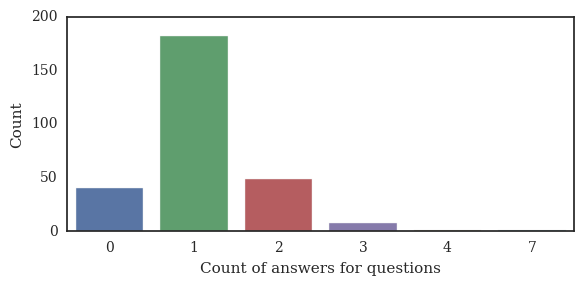

In [77]:
questions = psql.read_sql("""
SELECT * FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id
WHERE q.created_at < '2017-01-02' AND q.created_at >= '2016-09-26' AND q.deleted=false AND q.category_id <> 2
""", connection)
display(questions['answers_count'].describe())

fig = plt.figure()
ax = sns.countplot(questions["answers_count"])
ax.set(xlabel='Count of answers for questions', ylabel='Count')
fig.set_size_inches(6, 3)
fig.tight_layout()
fig.savefig('questions-answers.svg', format='svg')

count    4618.000000
mean        0.104591
std         1.862415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        88.000000
Name: answers_count, dtype: float64
Median: 	0.0

count    4618.000000
mean        0.108705
std         0.852754
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        31.000000
Name: questions_count, dtype: float64
Median: 	0.0

count    4618.000000
mean        0.127328
std         1.681038
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        73.000000
Name: comments_count, dtype: float64
Median: 	0.0


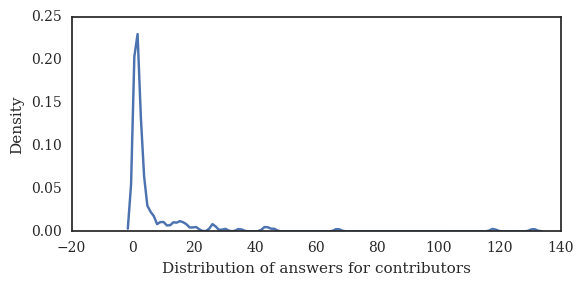

In [78]:
users = psql.read_sql("SELECT * FROM users WHERE created_at < '2017-01-02'", connection)
print(users['answers_count'].describe())
print('Median: \t'+str(users['answers_count'].median()))
print('')
print(users['questions_count'].describe())
print('Median: \t'+str(users['questions_count'].median()))
print('')
print(users['comments_count'].describe())
print('Median: \t'+str(users['comments_count'].median()))

users['ans_plus_comments'] = users['answers_count'] + users['comments_count']
fig = plt.figure()
ax = sns.distplot(users["ans_plus_comments"].loc[(users["ans_plus_comments"] > 0) ], hist=False, 
                  kde=True, rug=False)
ax.set(xlabel='Distribution of answers for contributors', ylabel='Density')
fig.set_size_inches(6, 3)
fig.tight_layout()
fig.savefig('contributions.svg', format='svg')